# Synaptome parameterization example

Adds physiological parameter values drawn from pathway-specific model distributions to all synapses in a synaptome (i.e., a circuit of scale "single").

In [1]:
import obi_one as obi
from entitysdk import Client, ProjectContext, models
from obi_auth import get_token
from obi_notebook import get_projects, get_entities, get_environment
from pathlib import Path

In [2]:
# environment= get_environment.get_environment()
environment = "staging"
token = get_token(environment=environment)

project_context = get_projects.get_projects(token=token, env=environment)

[2025-11-27 17:35:05,970] INFO: Local server listening on http://localhost:58511
[2025-11-27 17:35:05,971] INFO: Authentication url: https://staging.openbraininstitute.org/auth/realms/SBO/protocol/openid-connect/auth?response_type=code&client_id=obi-entitysdk-auth&redirect_uri=http%3A%2F%2Flocalhost%3A58511%2Fcallback&scope=openid&code_challenge=gFrBCaXsK56hwXZeMrqrQ6Q9dD6pZx2dVLRDaM22w7Y&code_challenge_method=S256&kc_idp_hint=github
[2025-11-27 17:35:07,052] INFO: HTTP Request: POST https://staging.openbraininstitute.org/auth/realms/SBO/protocol/openid-connect/token "HTTP/1.1 200 OK"


Dropdown(description='Select:', options=(('My first project', {'id': '7a411785-6895-4839-aaa2-d9f76e09875a', '…

In [3]:
client = Client(project_context=project_context, token_manager=token, environment=environment)

### Select a synaptome

In [4]:
synaptomes = get_entities.get_entities(
    entity_type="circuit",
    exclude_scales=["pair", "small", "microcircuit", "region", "system", "whole_brain"],
    add_columns=["build_category"],
    token=token,
    env=environment,
    project_context=project_context,
    multi_select=False,
    result=[],
)

DataGrid(auto_fit_params={'area': 'all'}, column_widths={'id': 250, 'name': 250, 'description': 250, 'brain_re…

In [26]:
# # Manual search for EM synaptome (i.e., Circuit with scale "single" and build category "em_reconstruction")
# synaptomes = client.search_entity(entity_type=models.Circuit, query={"scale": "single", "build_category": "em_reconstruction"}).all()
# assert len(synaptomes) > 0, "ERROR: No synaptomes built from EM found!"

# for syn in synaptomes:
#     print(f"{syn.name} (ID {syn.id})")

In [5]:
# Define MEModelWithSynapsesCircuitFromID by copy-pasting one of the above IDs
# synaptome_id = "<PASTE-ID-HERE>"

# OR use the selected one from the table
synaptome_id = synaptomes[0]

synaptome_from_id = obi.MEModelWithSynapsesCircuitFromID(id_str=synaptome_id)

### Define pathway physiology
In this example, synaptic conductance and type will be parameterized.

In [6]:
synapse_classes = ["excitatory_neuron", "inhibitory_neuron", "extrinsic_neuron"]
shared_within = False  # Drawn values are shared between all synapses of the same connection; otherwise values are independently drawn

# Example values for EXC synapses
distr_types_exc = {
    "conductance": {"type": "gamma", "mean": 1.0, "std": 0.5, "shared_within": shared_within},
    "syn_type_id": {"type": "constant", "mean": 100, "dtype": "int", "shared_within": shared_within},
}

# Example values for INH synapses
distr_types_inh = {
    "conductance": {"type": "gamma", "mean": 2.0, "std": 0.5, "shared_within": shared_within},
    "syn_type_id": {"type": "constant", "mean": 1, "dtype": "int", "shared_within": shared_within},
}
synapse_class_to_dict = {
    "excitatory_neuron": distr_types_exc,
    "extrinsic_neuron": distr_types_exc,
    "inhibitory_neuron": distr_types_inh
}

prop_stats = {
    _prop: {
        _src: {
            _tgt: synapse_class_to_dict[_src][_prop] for _tgt in synapse_classes
        } for _src in synapse_classes
    } for _prop in distr_types_exc.keys()
}


config_init = obi.SynapseParameterizationSingleConfig.Initialize(
    synaptome=synaptome_from_id,
    pathway_property = "synapse_class",
    pathway_param_dict={"src_types": synapse_classes,
                        "tgt_types": synapse_classes,
                        "prop_stats": prop_stats},
    random_seed=123456,
    overwrite_if_exists=False,  # Use this option for re-parameterizing existing physiology
)
task_config = obi.SynapseParameterizationSingleConfig(initialize=config_init, coordinate_output_root="synaptome")

### Run parameterization task

In [7]:
task = obi.SynapseParameterizationTask(config=task_config)

In [ ]:
res = task.execute(db_client=client, entity_cache=True)

### Check the parameterized synaptome

synaptome_afferents: 3868 synapses
      @source_node  conductance  syn_type_id
0                0     1.160075          100
1                1     1.627967          100
2                2     0.836222          100
3                3     0.562891          100
4                4     0.233207          100
...            ...          ...          ...
3863           324     2.219743            1
3864          3495     1.000110          100
3865          2298     1.733795            1
3866          3496     0.671643          100
3867           456     0.519988          100

[3868 rows x 3 columns]


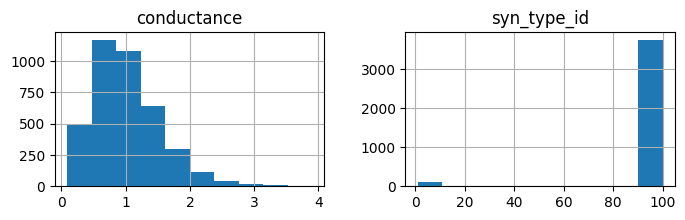

In [18]:
physiol_props = task._pathway_model.prop_names
npop = task._synaptome.default_population_name
synaptome = task._synaptome.sonata_circuit
for epop in synaptome.edges.population_names:
    edges = synaptome.edges[epop]
    print(f"{epop}: {edges.size} synapses")
    syn_table = edges.afferent_edges(node_id=0, properties=["@source_node"] + physiol_props)
    print(syn_table)
    syn_table[physiol_props].hist(figsize=(8, 2))